# Week 3

In [114]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [117]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [118]:
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign','pdays', 'previous', 'poutcome', 'y']

In [119]:
df = df[features]

In [120]:
# df = df.drop('loan', axis=1)

In [121]:
[col for col in df.columns if df[col].isnull().any()]

[]

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [123]:
df['education'].value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [124]:
matrix = df.select_dtypes(include='number').corr()

In [125]:
matrix

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


<Axes: >

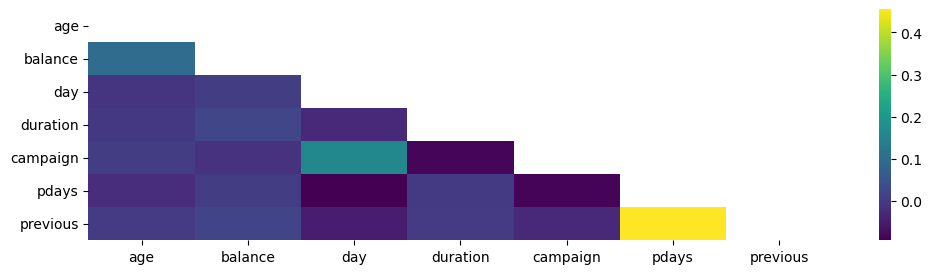

In [126]:
plt.figure(figsize=(12, 3), frameon=False)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, mask=mask, cmap='viridis')

## Target encoding

In [127]:
df['y'] = (df['y'] == 'yes').astype('int')

## Splitting the data

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [130]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [131]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [132]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [133]:
del df_train['y']
del df_val['y']
del df_test['y']

## Mutual information

In [134]:
from sklearn.metrics import mutual_info_score

In [135]:
mutual_info_scores = {}
for col in df_train.select_dtypes(exclude='number').columns:
    mutual_info_scores[col] = round(mutual_info_score(y_train, df_train[col]), 2)

In [136]:
print(dict(sorted(mutual_info_scores.items(), key=lambda item: item[1])))

{'marital': np.float64(0.0), 'education': np.float64(0.0), 'job': np.float64(0.01), 'housing': np.float64(0.01), 'contact': np.float64(0.01), 'month': np.float64(0.03), 'poutcome': np.float64(0.03)}


## One-Hot Encoding

In [155]:
from sklearn.feature_extraction import DictVectorizer

In [138]:
categorical = list(df_train.select_dtypes(exclude='number').columns)

In [157]:
dv = DictVectorizer(sparse=False)

In [160]:
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Logistic regression

In [162]:
from sklearn.linear_model import LogisticRegression

In [163]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [165]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [171]:
y_pred = model.predict_proba(X_val)[:,1]

In [172]:
decision = (y_pred > 0.5) 

In [175]:
(y_val == decision).mean()

np.float64(0.9009068790090687)